In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
#Using Tesla stock az
df=pd.read_csv("/content/TSLA.csv")
#Verifying dataset import
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1500,2020-12-16,209.410004,210.833328,201.666672,207.589996,207.589996,126287400
1501,2020-12-17,209.396667,219.606674,206.500000,218.633331,218.633331,168810300
1502,2020-12-18,222.966660,231.666672,209.513336,231.666672,231.666672,666378600
1503,2020-12-21,222.080002,222.833328,215.356674,216.619995,216.619995,174135900
1504,2020-12-22,216.000000,216.626663,204.743332,213.446671,213.446671,155148000
1505,2020-12-23,210.733337,217.166672,207.523331,215.326660,215.326660,99519000
1506,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
1507,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
1508,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
1509,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000


In [3]:
#Preprocessing Data
print(df.describe())
print("---"*10)
#Changing the values in the Date Column to datetime datatype
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())
#data.set_index('Date', inplace=True)
print("---"*10)
#Checking for missing values
missing_vals = df.isnull().sum()
print(missing_vals)
#Splitting the dataset into training and testa
training = df.iloc[:800, 1:2].values
testing = df.iloc[800:, 1:2].values
print("---"*10)
#Since LSTM is senstivite to Scale,We use MinMax to standardize the scale of the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_scaled = sc.fit_transform(training)

              Open         High          Low        Close    Adj Close  \
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000   
mean     30.921814    31.621175    30.198765    30.976507    30.976507   
std      36.948396    37.993719    35.848150    37.139818    37.139818   
min       9.488000    10.331333     9.403333     9.578000     9.578000   
25%      15.179500    15.391334    14.938667    15.139667    15.139667   
50%      18.877334    19.214666    18.497333    18.944000    18.944000   
75%      23.163501    23.485835    22.814500    23.162333    23.162333   
max     224.836670   232.199997   222.786667   231.666672   231.666672   

             Volume  
count  1.510000e+03  
mean   1.203075e+08  
std    8.891357e+07  
min    1.062000e+07  
25%    6.385538e+07  
50%    9.240750e+07  
75%    1.432407e+08  
max    9.140820e+08  
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 7 columns)

In [15]:

# Normalize the df
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # You can adjust this hyperparameter
X, y = create_sequences(df, sequence_length)

x_train = []
y_train = []
for iter in range(60, 800):
    x_train.append(training_scaled[iter-60:iter, 0])
    y_train.append(training_scaled[iter, 0])
x_train, y_train=np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [16]:
#Creating a LSTM model for prediction
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

#Printing a overview of the model
model.summary()

#Compiling and Fitting the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50, batch_size = 32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [20]:
df = pd.read_csv("TSLA.csv")
data_train = df.iloc[:800, 1:2]
data_test = df.iloc[800:, 1:2]
data_total = pd.concat((data_train, data_test), axis = 0)
total_input = data_total[len(data_total) - len(data_test) - 60:].values
total_input = total_input.reshape(-1,1)
total_input = sc.transform(total_input)
x_test = []
for iter in range(60, 770):
    x_test.append(total_input[iter-60:iter, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

predicted_price = model.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)
#print(data_test)
print(len(predicted_price))

(710, 60, 1)
23/23 [==============================] - 1s 30ms/step
            Open
800    22.190666
801    21.606667
802    21.907333
803    21.907333
804    22.450666
...          ...
1505  210.733337
1506  214.330002
1507  224.836670
1508  220.333328
1509  224.000000

[710 rows x 1 columns]
710


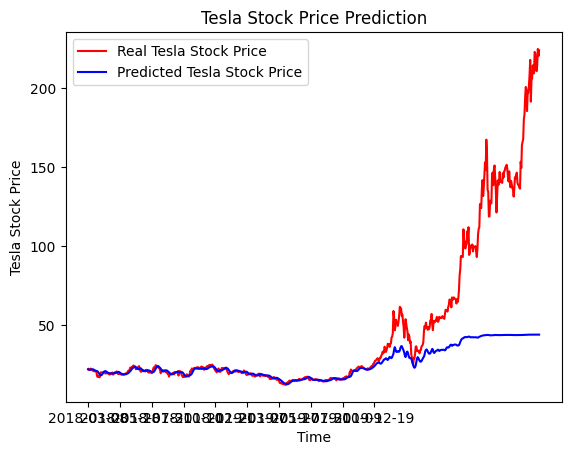

In [22]:
plt.plot(df.loc[800:, 'Date'],data_test.values, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_price, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Performance Metrics
y_train_pred = model.predict(data_train)
y_test_pred = model.predict(data_test)

# Inverse transform the predicted prices to their original scale
predicted_price = sc.inverse_transform(predicted_price)

# Display the number of predicted prices
print("Number of Predicted Prices:", len(predicted_price))


y_train_actual = scaler.inverse_transform(data_train)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_actual = scaler.inverse_transform(data_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

train_rmse = np.sqrt(mean_squared_error(data_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(data_test, y_test_pred))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)



23/23 [==============================] - 0s 3ms/step
Number of Predicted Prices: 710
Train RMSE: 16.815131088550885
Test RMSE: 67.27047773743399
